## Step 1 - Convolutional neural network for environmental sound classification
The following notebook includes the code used to replicate the approach from the article [Environmental Sound Classification with Convolutional Neural Networks](http://karol.piczak.com/papers/Piczak2015-ESC-ConvNet.pdf). The results are obtained by running 10-fold cross validation. 

**NOTE:** The idea was orignally to obtain a performance comparable to piczak, but since we changed the project plan with our supervisor from Corti, we did not further improve the performance and went on to step 2, where the code is included in the other jupyter notebook. 

### DATASET ###
You need to download the urban-sound-8k dataset from:
https://serv.cusp.nyu.edu/projects/urbansounddataset/urbansound8k.html

The data needs to be put into a ./datasets/ folder. 

The dataset consists of 8732 labelled sound clips 4 seconds each
They belong to 10 different categories


In [1]:
from __future__ import division
import numpy as np
import glob
import os
import librosa
import librosa.display
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras import regularizers
from keras.optimizers import SGD
import platform
from keras.models import load_model
import sys
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import class_weight

# Random seed for reproducibility
np.random.seed(1337)


Using Theano backend.


## Dataloading and pre-processing
First we define the path to the datasets. The data is split into 10 folds beforehand. 

In [2]:
seperator = '/'
if platform.system() == 'Windows':
    seperator = '\\'

file_ext = "*.wav"
# for working on both linux and windows
data_path = os.path.join('..', 'datasets', 'UrbanSound8K', 'audio')

data_dirs = map(lambda d: os.path.join(data_path, d, file_ext), 
                ['fold1', 'fold2', 'fold3', 'fold4', 'fold5', 'fold6', 
                 'fold7', 'fold8', 'fold9', 'fold10'])




Next, we define the loading method. Since the sounds are of varying length, we pad 0's to clips with length < 4s.

In [3]:
def load_sample(file_name, max_segment_size = 88200):
    # length of raw sound is 88200 with sample_rate = 22050Hz which is 4 sec
    label = file_name.split(seperator)[5].split('-')[1]
    sound_raw, sample_rate = librosa.load(file_name)
    # Normalize sound
    # According to its own max? or wtf
    normalization_factor = 1 / np.max(np.abs(sound_raw))
    sound_raw = sound_raw * normalization_factor

    # Pad zeroes to raw sound
    num_zeros = max_segment_size - len(sound_raw)
    append_array = np.zeros(num_zeros)
    sound_raw = np.append(sound_raw, append_array)

    return sound_raw, label

Feature extraction is performed using the librosa library. Furthermore, we add delta-features which is local estimate of the derivative of the input data along the selected axis.

In [4]:
def extract_feature_cnn(sound_raw, n_fft = 1024, hop_length = 512, bands = 60):
    """
    @return: shape = (features, bands, frames) for 4 sec
    """
    melspec = librosa.feature.melspectrogram(sound_raw, sr=22050, n_mels=bands, n_fft=1024, hop_length=hop_length)
    logspec = librosa.logamplitude(melspec)
    delta = librosa.feature.delta(logspec)
    features = np.concatenate((np.expand_dims(logspec, 0), np.expand_dims(delta, 0)), axis=0)
    return features

Piczak splits the data into overlapping segments (he argues this is because the small size of the dataset) and then use a either a majority voting scheme or a probability voting scheme to perform the final classifications. We adopt his method. The dataset is split into either a 50% overlapping window consisting of ~950ms clips or 90% overlapping window consisting of ~2,3s clips. The following rolling window method does this. 

In [5]:
def rolling_window(ts, window, stride = 1):
    """
    Rolling window cutting off the last window if ts is not long enough.
    Based on http://www.rigtorp.se/2011/01/01/rolling-statistics-numpy.html
    
    @return: ((features), band, frames, section_size) = (60, 41, ?)
    """

    # Number of jumps (segments)
    num_jumps = int((ts.shape[-1] - window)/stride + 1)

    # discard the end of the clip
    ts = ts[...,:stride * num_jumps + (window-stride)]

    # shape = (2,60,?,41)
    shape = ts.shape[:-1] + (num_jumps, window)
    strides = ts.strides[:-1] + (stride * ts.strides[-1], ts.strides[-1])


    return np.lib.stride_tricks.as_strided(ts, shape=shape, strides=strides)

We also convert the labels into one-hot encodings. We do this with the following method. 

In [6]:
def one_hot_encode(labels):
    """
    @param labels: array of integer labels between [0, n].
    """
    n_labels = len(labels)
    # Todo: why +1? and fix hacks (not neccesary)
    n_unique_labels = max(labels) + 1
    n_unique_labels = 10
    one_hot_encode = np.zeros((n_labels, n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1

    return one_hot_encode

Since we train on the segments, but evaluate our model on the actual sound clips we need a to keep track of segments belonging together. Furthermore, we discard segments that are silent. We do this with the following method.

In [7]:
def squeeze_segments(X, y):
    """
    :param X: [(segments, channels, bands, windows)]
    :param y: one-hot vectors as labels
    :return:
    """
    X_data = []
    y_data = []
    segment_sizes = []
    for index, sample in enumerate(X):
        num_segments = 0
        for i in range(sample.shape[0]):
            # Filter silent segments
            if np.mean(sample[i,0,:,:]) > -50:
                X_data.append(sample[i])
                y_data.append(y[index])
                num_segments += 1

        segment_sizes.append(num_segments)

    return np.asarray(X_data), np.asarray(y_data), np.asarray(segment_sizes)

All of the above methods are used in a data-loading loop which loads all of the data into memory. 

In [8]:
def load_data(dirs, stride, window, test=False):
    """
    data_X.shape = (num_samples, features, bands, segments, frames_pr_segment)
    data_y.shape = if one_hot then (num_samples, num_categories) else (num_samples, )
    """

    print("Loading data...")
    
    data_y = []
    data_X = []
    segment_sizes = []

    for dir_ in dirs:
        temp_data_X = []
        temp_data_y = []
        test_counter = 0

        for fn in glob.glob(dir_):
            if test:
                test_counter += 1
                if test_counter == 100:
                    break
            try:
                # Split into segments
                raw_sound, label = load_sample(file_name=fn)

                # Extract feature
                features = extract_feature_cnn(raw_sound,
                                              n_fft = 1024, hop_length = 512)

                # Create segments
                x = rolling_window(features, window=window, stride=stride)

                # Swap axis so segments is first (2,60,?,41) --> (?,2,60,41)
                x = np.swapaxes(x, 1, 2)
                x = np.swapaxes(x, 0, 1)

                # Append each label and sample
                temp_data_X.append(x)
                temp_data_y.append(int(label))
    
            except Exception as e:
                print("Error encountered while parsing file: ", fn)
                continue

        # Create one hot encoded y values
        temp_data_y = one_hot_encode(temp_data_y)

        # Squeese data so each segment is regarded one training sample
        temp_data_X, temp_data_y, temp_segment_sizes = squeeze_segments(temp_data_X, temp_data_y)

        print("{0} - Shape of X: {1}".format(dir_[31:36], temp_data_X.shape))
        print("{0} - Shape of y: {1}".format(dir_[31:36], temp_data_y.shape))
        print("{0} - Number of samples in each category: {1}".format(dir_[31:36], np.sum(temp_data_y, axis=0)))

        segment_sizes.append(temp_segment_sizes)
        data_X.append(temp_data_X)
        data_y.append(temp_data_y)
    
    return data_X, data_y, segment_sizes


When performing 10-fold cross-validation, we interchange between which folds are used for testing, validation and training. We use 1 fold for testing, 2 folds for evaluation and do this 10-times. 

In [9]:
def divide_into_folds(X, y, current_index):
    """
    :param X: List with X data from our 10 folds
    :param y: List with y data from our 10 folds
    :param current_index: Currently using fold current_index as test
    :return: split
    """
    test_X = X[current_index % 10]
    test_y = y[current_index % 10]

    val_X = list(X[i] for i in [(current_index + 1) % 10, (current_index + 2) % 10])
    val_y = list(y[i] for i in [(current_index + 1) % 10, (current_index + 2) % 10])

    val_X = np.asarray([sample for fold in val_X for sample in fold])
    val_y = np.asarray([sample for fold in val_y for sample in fold])

    train_X = list(X[i] for i in [(current_index + 3) % 10, (current_index + 4) % 10, (current_index + 5) % 10,
                                (current_index + 6) % 10, (current_index + 7) % 10, (current_index + 8) % 10,
                                (current_index + 9) % 10])

    train_y = list(y[i] for i in [(current_index + 3) % 10, (current_index + 4) % 10, (current_index + 5) % 10,
                                (current_index + 6) % 10, (current_index + 7) % 10, (current_index + 8) % 10,
                                (current_index + 9) % 10])

    train_X = np.asarray([sample for fold in train_X for sample in fold])
    train_y = np.asarray([sample for fold in train_y for sample in fold])

    train_X = np.asarray(train_X)
    train_y = np.asarray(train_y)
    
    return (test_X, test_y), (val_X, val_y), (train_X, train_y)

## Architecture
The model architecture is exactly as Piczak. The following method builds his model using keras. 

In [10]:
def build_model(train_X, train_y, learning_rate):
    """
    From Pizak
    The first convolutional ReLU layer consisted of 80 filters
    of rectangular shape (57x6 size, 1x1 stride) allowing
    for slight frequency invariance. Max-pooling was applied
    with a pool shape of 4x3 and stride of 1x3

    Run `squeeze_segment` to get the required shape.
        
    @param train_X: (samples * segments, features, bands, frames_pr_sections)
    @param train_y: (samples * segments, num_categories)
    """
    
    print("Building model...")
    input_dim = train_X[0][0].shape
    output_dim = train_y[0].shape[1]

    print("Input dim: {0}".format(input_dim))
    print("Output dim: {0}".format(output_dim))
    
    model = Sequential()
    
    shared_kwargs = { 'data_format': 'channels_first' }
    
    # important that train_X has shape (samples, channels, rows, cols)
    model.add(Conv2D(80, kernel_size=(57, 6), strides=(1, 1),
                     activation='relu',
                     input_shape=input_dim,
                     kernel_regularizer=regularizers.l2(0.001),
                     **shared_kwargs))
    
    model.add(MaxPooling2D(pool_size=(4, 3), strides=(1, 3), **shared_kwargs))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(80, kernel_size=(1, 3), strides=(1, 1),
                     activation='relu',
                     kernel_regularizer=regularizers.l2(0.001),
                     **shared_kwargs))
    
    model.add(MaxPooling2D(pool_size=(1, 3), strides=(1, 3), **shared_kwargs))
    
    model.add(Flatten())
    
    # Layer 1
    model.add(Dense(5000, kernel_regularizer=regularizers.l2(0.001)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    # layer 2
    model.add(Dense(5000, kernel_regularizer=regularizers.l2(0.001)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    # layer
    model.add(Dense(output_dim))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy',
                  optimizer=SGD(lr=learning_rate, nesterov=True, momentum=0.9),
                  metrics=["accuracy"])

    return model


## Training and evaluation
For each interchange of folds, we have a method which trains the model and saves it. We only save the models with the best evaluation accuracy. 

In [11]:
def train_model(model, train_X, train_y, val_X, val_y, current_fold, epochs=200, ):
    print("Training model...")
    early_stopping = EarlyStopping(monitor='val_acc', patience=15)

    # Callbacks for saving best autoencoder
    filepath = "trained_models/piczak-{0}.hdf5".format(current_fold)
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='auto')

    model.fit(train_X, train_y, epochs=epochs, batch_size=1000,
              validation_data=(val_X, val_y),
              verbose=2,
              callbacks=[early_stopping, checkpoint])

We evaluate our model for each fold-split using the following functions. We have both majority voiting and probability voting scheme implemented. 

In [12]:
def majority_vote(predictions):
    # Majority voting
    # Currently favorizes the first categories
    predictions_array = np.zeros(10)
    for prediction in predictions:
        predictions_array[np.argmax(prediction)] += 1

    # Returns the first index if multiple max values
    return np.argmax(predictions_array)
    
def accuracy(predicted, expected):
    return np.sum(np.equal(predicted, expected)) / len(predicted)

def evaluate(current_fold, test_X, test_y, segment_sizes):
    """
    @param: test_X shape (samples * segments, features, bands, frames_pr_sections)
    @param: test_y shape (samples,)
    """

    assert test_y.shape[0] == np.sum(segment_sizes)
    
    print("Evaluating model...")
    model = load_model("trained_models/piczak-{0}.hdf5".format(current_fold))
    all_predictions = model.predict(test_X)

    # Decode one-hot vectors into single labels
    test_y = np.argmax(test_y, axis=1)

    predictions_prob = []
    predictions_majority = []
    singe_test_y = []
    current_index = 0
    for segment_size in segment_sizes:
        predictions_prob.append(np.argmax(np.sum(all_predictions[current_index:current_index+segment_size], axis=0)))
        predictions_majority.append(majority_vote(all_predictions[current_index:current_index+segment_size]))
        singe_test_y.append(test_y[current_index])
        current_index += segment_size

    predictions_prob_acc = accuracy(np.asarray(predictions_prob), np.asarray(singe_test_y))
    predictions_majority_acc = accuracy(np.asarray(predictions_majority), np.asarray(singe_test_y))
    
    print("Test accuracy using majority voting: {}".format(predictions_prob_acc))
    print("Test accuracy using probability voting: {}".format(predictions_majority_acc))

    return [predictions_prob, singe_test_y], [predictions_majority, singe_test_y], predictions_prob_acc, predictions_majority_acc

At last, we the evaluation and training methods in a loop. Since we have 10 different folds to be used for testing, we have a simple for-loop of 10 iterations.  

In [13]:
def training_with_10foldCV(X, y, segment_sizes, epochs, learning_rate):
    print("Performing 10foldCV...")

    erros_prob = []
    erros_maj = []
    predictions_prob = []
    predictions_maj = []
    # X and y has to have dimensions 10
    for i in range(10):
        # Divide into train, test and validation
        print("Using fold{0} as test".format(i+1))

        model = build_model(X, y, learning_rate)
        test, val, train = divide_into_folds(X, y, i)
        train_model(model, train[0], train[1], val[0], val[1], i, epochs=epochs)

        # Evaluate the trained model
        prob_predictions, maj_predictions, prob_acc, maj_acc = evaluate(i, test[0], test[1], segment_sizes[i])

        erros_prob.append(prob_acc)
        erros_maj.append(maj_acc)
        predictions_prob.append(prob_predictions)
        predictions_maj.append(maj_predictions)

    return predictions_prob, predictions_maj, erros_prob, erros_maj

## Saving data to CSV
The interesting plots are a confusion matrix or box-plots with the evaluations from each fold. We save the test predictions and test errors to csv format, in order to easily construct plots of the results. 

In [14]:

def predictions_to_csv(probability, majority, final_output_prefix):
    # Flatten predictions from folds
    prob = []
    maj = []

    for fold in probability:
        assert len(fold[0]) == len(fold[1])
        for pair in zip(fold[0], fold[1]):
            prob.append(pair)

    for fold in majority:
        assert len(fold[0]) == len(fold[1])
        for pair in zip(fold[0], fold[1]):
           maj.append(pair)


    df_prob = pd.DataFrame(prob, columns=['prediction', 'actual'])
    df_maj = pd.DataFrame(maj, columns=['prediction', 'actual'])

    df_prob.to_csv(final_output_prefix + 'predictions_probability.csv', index=False)
    df_maj.to_csv(final_output_prefix + 'predictions_majority.csv', index=False)


def accuracy_to_csv(prob_acc, maj_acc, final_output_prefix):
    acc_dict = {'probability' : prob_acc,
                'majority' : maj_acc
                }

    df = pd.DataFrame(acc_dict)
    df.to_csv(final_output_prefix + 'accuracy.csv', index=False)

Now we have everything and are ready to begin training and saving of data. 

In [15]:
def main(final_output_prefix, short_segments=False, long_segments=False, test=False):
    epochs = 0
    stride = 0
    window = 0
    raw_segment_size = 0
    learning_rate = 0

    # Take the exact values as piczak
    if short_segments:
        epochs = 300
        stride = 20
        window = 41
        learning_rate =  0.002
    elif long_segments:
        epochs = 150
        stride = 50
        window = 101
        learning_rate = 0.01
    else:
        print("You need to specify which version of piczak to train")
        return
    if test:
        epochs = 2

    # Gets a two list with the data
    X, y, segment_sizes = load_data(data_dirs, stride, window, test=test)

    predictions_prob, predictions_maj, erros_prob, erros_maj = \
        training_with_10foldCV(X, y, segment_sizes, epochs=epochs, learning_rate=learning_rate)

    predictions_to_csv(predictions_prob, predictions_maj, final_output_prefix)
    accuracy_to_csv(erros_prob, erros_maj, final_output_prefix)

    print("Everything went well! :D")

In [ ]:
# Set these values to alter between models
# Note: Important to change prefix to the outputted csv files
main(final_output_prefix="pic_short", 
     short_segments=True,
     long_segments=False,
     test=False)

## Visualization of results

All of our models were trained on DTU's HPC cluster available for all students. We used titanx GPU's for training. Training took ~5-7 hours with this setup depending on whether we were using long-segments or short-segments. The CSV files are included in this repository, in order to visualize the results. Again, piczak used 2-different segment sizes and 2-different voting schemes. Therefore, we have 4 different models.  

### Boxplot
First, we show a box-plot of our results of the 4 models. 

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from sklearn.metrics import confusion_matrix
import itertools
from matplotlib.backends.backend_pdf import PdfPages
import plotly
from plotly.offline import plot
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot_mpl
import plotly.offline as offline


init_notebook_mode()

def boxplot_plot(data_short, data_long, save_to='my_boxplot.png'):
    trace0 = go.Box(
        y=data_short["majority"],
        name="SM",
        boxpoints=False,
        boxmean=True,
        marker=dict(
            color='rgb(7,40,89)'),
        line=dict(
            color='rgb(7,40,89)')
    )

    trace1 = go.Box(
        y=data_short["probability"],
        name="SP",
        boxpoints=False,
        boxmean=True,
        marker=dict(
            color='rgb(9,56,125)'),
        line=dict(
            color='rgb(9,56,125)')
    )


    trace2 = go.Box(
        y=data_long["majority"],
        name="LM",
        boxpoints=False,
        boxmean=True,
        marker=dict(
            color='rgb(8,81,156)'),
        line=dict(
            color='rgb(8,81,156)')
    )

    trace3 = go.Box(
        y=data_long["probability"],
        name="LP",
        boxpoints=False,
        boxmean=True,
        marker=dict(
            color='rgb(107,174,214)'),
        line=dict(
            color='rgb(107,174,214)')
    )

    boxes = [trace0, trace1, trace2, trace3]

    layout = go.Layout(
        title="Performance evaluation"
    )
    
    fig = go.Figure(data=boxes, layout=layout)

    #py.iplot(fig, filename='styled_bar')
    offline.plot({'data':boxes, 
                  'layout':layout},
                  auto_open=False, image = 'png', image_filename='bp',
             output_type='file', image_width=800, image_height=600, 
             filename='temp-plot.html', validate=False)
    
    

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [17]:
def load_bp_data(data_file):
    """
    Loads the data into a pandas df
    :param bp_file: path to the csv file
    :return: pandas dataframe
    """
    data = pd.read_csv(data_file)

    return data

def main_plot(bp_short=None, bp_long=None):

    # load data for boxplot
    if bp_short != None and bp_long != None:
        short = load_bp_data(bp_short)
        long = load_bp_data(bp_long)
        boxplot_plot(short, long, save_to='.results-piczak/boxplot.png')

    return


In [18]:
main_plot(bp_short='./results-piczak/short_10foldCV/acc_short_10foldCV.csv',
     bp_long='./results-piczak/long_10foldCV/acc_long_10foldCV.csv')

The main_plot method outputs and html file which is converted to png when opened. We include the png file here. LM is long-segments majority voting scheme, and LP is long-segments probability voting scheme. The same is true for SM and SP, just with short-segments. 

![](./results-piczak/bp.png?raw=true)

The short-segment models are almost comparable to what piczak achieved. Piczak however achieved considerable better performance on the long-segment models. Improvements could possible have been made, but as mentioned in the beginning, we decided to focus on semi-supervised learning instead. 

## Confusion matrix
Since our SP model achieved the highest mean performance, we only include the confusion matrix for this. 

In [19]:
def confusion_matrix_plot(data_prob, save_to='cm.pdf'):
    categories = ['air conditioner', 'carhorn', 'children playing', 'dog bark',
                  'drilling', 'engine idling', 'gun shot', 'jackhammer',
                  'siren', 'street music']

    conf_arr = confusion_matrix(data_prob['actual'], data_prob['prediction'])

    norm_conf = []
    for i in conf_arr:
        a = 0
        tmp_arr = []
        a = sum(i, 0)
        for j in i:
            tmp_arr.append(float(j) / float(a))
        norm_conf.append(tmp_arr)

    norm_conf = np.array(norm_conf)
    fig = plt.figure()
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    res = ax.imshow(norm_conf, cmap=plt.cm.Reds,
                    interpolation='nearest')

    fig.set_dpi(120)
    width, height = conf_arr.shape

    thresh = 0.32
    for x in range(width):
        for y in range(height):
            ax.annotate(str(conf_arr[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color="white" if norm_conf[x, y] > thresh else "black")


    cb = fig.colorbar(res)

    plt.xticks(range(width), categories[:width], rotation='vertical')
    plt.yticks(range(height), categories[:height])
    plt.subplots_adjust(bottom=0.30)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    plt.show()

def load_cm_data(cm_file):
    """
    Loads the data into a pandas df
    :param cm_file_prob: path to the csv file
    :param cm_file_maj: path to the csv file
    :return: two pandas dataframes with the data
    """
    data = pd.read_csv(cm_file)

    return data


def main(bp_short=None, bp_long=None, cm_file=None):
    # Load data for confusion matrix
    if (cm_file != None):
        data = load_cm_data(cm_file)
        confusion_matrix_plot(data)

    return

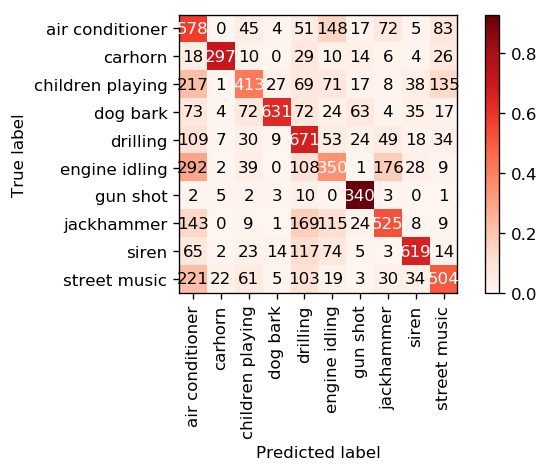

In [20]:
main(cm_file='./results-piczak/short_10foldCV/probability_short.csv')

Clearly, our model has learned something interesting and with mean accuracy of ~62% for the 10 folds, we also expect a confusion matrix with a coloured diagonal. Some clear faults are the drilling and air conditioner categories, which seems to be favored by the model. A lot of small improvements can be done in order to obtain the same 73% as Piczaks article, but again, this was not the goal of the project. 